In [1]:
pip install --upgrade InsufficientGibbs

  Attempting uninstall: InsufficientGibbs
    Found existing installation: InsufficientGibbs 1.0.7
    Uninstalling InsufficientGibbs-1.0.7:
      Successfully uninstalled InsufficientGibbs-1.0.7
Note: you may need to restart the kernel to use updated packages.


In [10]:
# from InsufficientGibbs.Distribution import *
# from InsufficientGibbs.Model import *
# from InsufficientGibbs.Distribution import Normal,InverseGamma
# from InsufficientGibbs.Models import NormalModel
from Distribution import Normal,InverseGamma
from Models import NormalModel
from Model import display_chains
import numpy as np
import seaborn as sns
from scipy.stats import t,invgamma,median_abs_deviation,norm
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [54]:
T = 100000
N = 1000


med_X, MAD_X = -2, 3


mu_0,sigma_0=0,3
alpha,beta=3, 50
par_prior_loc,par_prior_scale=[mu_0,sigma_0],[alpha,beta]

mu = Normal(mu_0,sigma_0,"$\mu$")
sigma2 = InverseGamma(beta,alpha,"$\sigma$")

norm_med_MAD = NormalModel(mu,sigma2)
Normal_MAD = norm_med_MAD.Gibbs_med_MAD(T,N,med_X,MAD_X)

100%|██████████| 100000/100000 [03:10<00:00, 524.45it/s]

Acceptation rates MH : $\mu$ = 100.00% $\sigma$ = 100.00% 


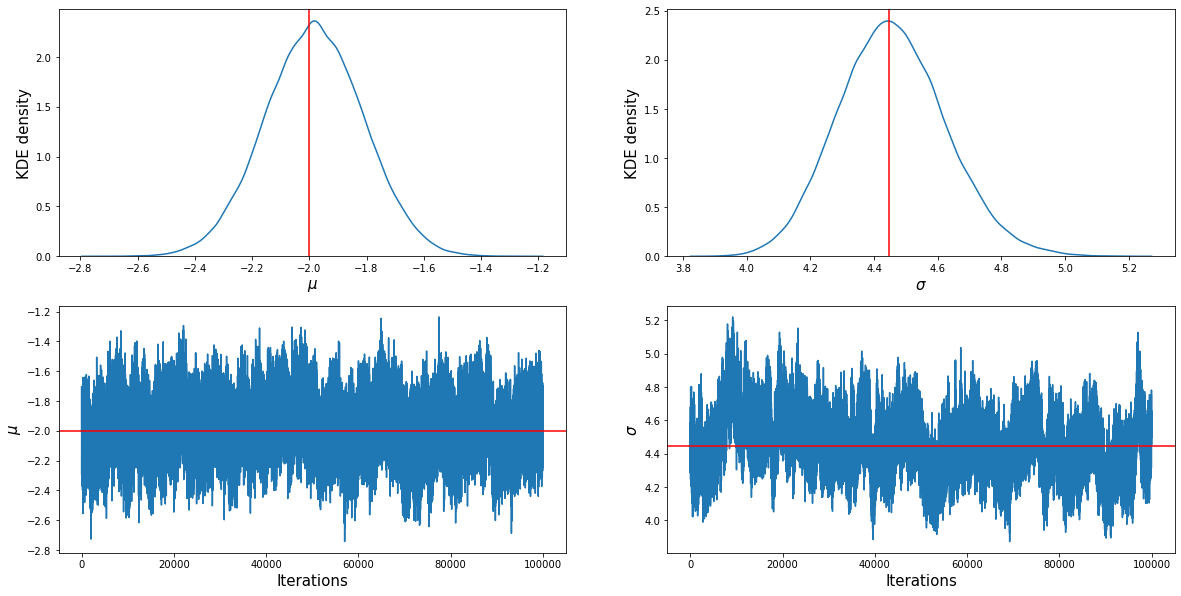

In [56]:
display_chains(Normal_MAD, true_par = [med_X,MAD_X/norm.ppf(3/4)])

## Test IQR

In [62]:
N

1000

In [71]:
from scipy.stats import lognorm

In [247]:
a=2
X = lognorm.rvs(s = 50, scale = np.exp(a), size = 100000)
med_X, MAD_X = np.median(X), median_abs_deviation(X)
np.log(med_X), 

(1.9087337729924312, 6.74454326654355)

In [139]:
np.log(med_X)

2.1335333901681515

In [137]:
X_norm = np.log(X)
median_abs_deviation(X_norm)/norm.ppf(3/4)

10.161651203764446

In [69]:
med, IQR = med_X, 2*MAD_X
norm_med_IQR = NormalModel(mu,sigma2)
Normal_IQR = norm_med_IQR.Gibbs_med_IQR(T//10,N,med,IQR)

N = 1000
I = [250 500 750]


100%|██████████| 10000/10000 [01:35<00:00, 104.24it/s]


Acceptance rate of the order statistics (250) = 36.59%
Acceptance rate of the order statistics (500) = 12.17%
Acceptance rate of the order statistics (750) = 31.59%
Acceptance rate of the order statistics (751) = 35.58%
Acceptation rates MH : $\mu$ = 100.00% $\sigma$ = 100.00% 


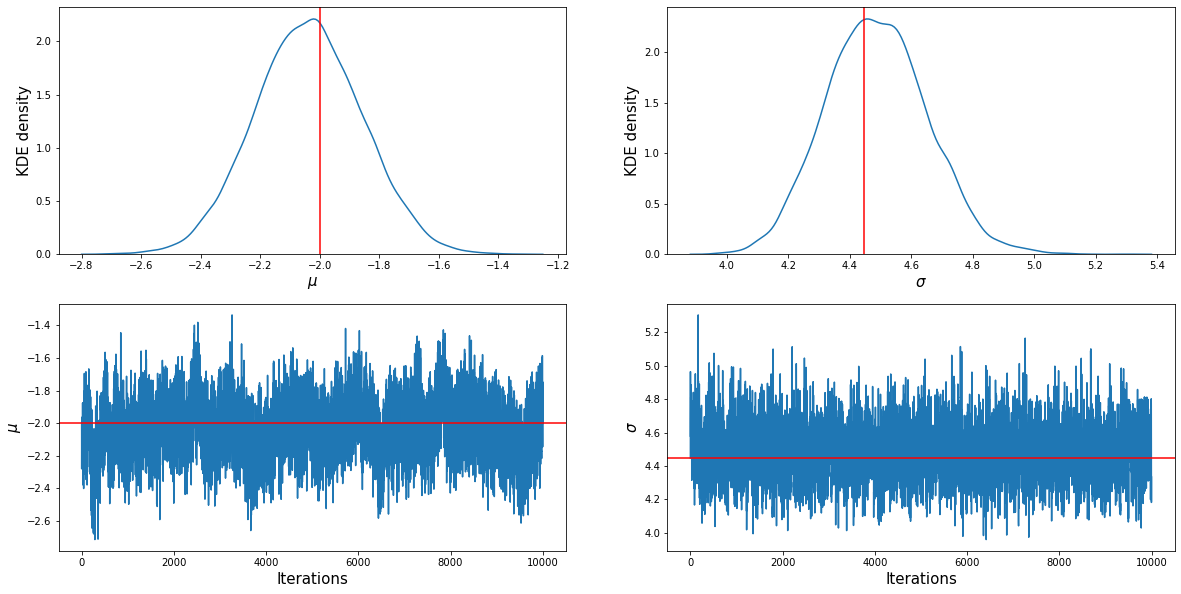

In [70]:
display_chains(Normal_IQR, true_par = [med, IQR/(2*norm.ppf(0.75))])

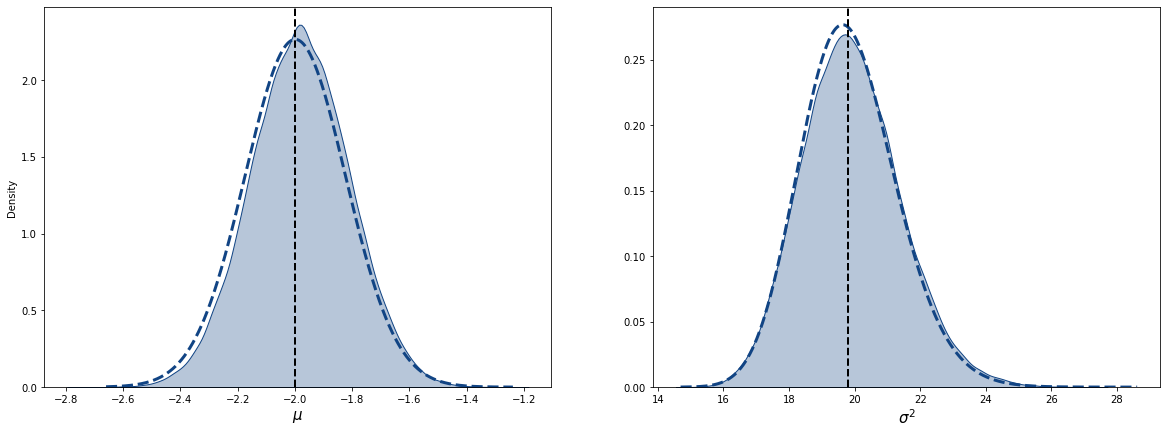

In [72]:
fig, ax = plt.subplots(1,2,figsize=(20,7))

dico_MAD = Normal_MAD

mu_chain,sigma2_chain = dico_MAD["chains"]["$\mu$"],np.array(dico_MAD["chains"]["$\sigma$"])**2
N=len(dico_MAD["X"][0])
med,MAD=med_X,MAD_X

c=1/norm.ppf(0.75)
S2= (c*MAD)**2

N_med,N_MAD=N * 2/np.math.pi,N*0.3674

nu = 1/sigma_0

alpha_MAD = alpha + N_MAD / 2
beta_MAD = beta+ (N_MAD * S2+ N_med * nu * (med - mu_0) ** 2 / (nu + N_med))/ 2
mu_MAD = (nu * mu_0 + N_med * med) / (nu + N_med)
nu_MAD = nu + N_med
loc_MAD=mu_MAD
scale_MAD=np.sqrt(beta_MAD/(alpha_MAD*nu_MAD))
df_MAD=2*alpha_MAD

sns.kdeplot(mu_chain,ax=ax[0],label="Insuffficient Gibbs",fill=True,alpha=.3,color="#114484")
ax[0].set_xlabel("$\mu$",fontsize=15)

sns.kdeplot(sigma2_chain,ax=ax[1],label="Insufficient Gibbs",fill=True,alpha=.3,color='#114484')



x = np.linspace(t.ppf(0.0001, df_MAD, loc=loc_MAD, scale=scale_MAD),
                t.ppf(0.99999, df_MAD, loc=loc_MAD, scale=scale_MAD), 1000)

ax[0].plot(x, t.pdf(x, df_MAD, loc=loc_MAD, scale=scale_MAD), '--', label='Approximation pdf (Student)',lw=3,color="#114484")

x = np.linspace(invgamma.ppf(0.00001, alpha_MAD, scale=beta_MAD),
                invgamma.ppf(0.999999, alpha_MAD, scale=beta_MAD), 1000)

ax[1].plot(x,invgamma.pdf(x, alpha_MAD, scale=beta_MAD),'--', label='Approximation pdf (InvGamma)',lw=3,color="#114484")

ax[0].axvline(x=med_X,linestyle="--",color="black",label="True $\mu$ value",lw = 2)

ax[1].axvline(x=(MAD_X*c)**2,linestyle="--",color="black",label="True $\sigma^2$ value",lw = 2)


ax[1].set_xlabel("$\sigma^2$",fontsize=15)
ax[1].set_ylabel("",fontsize=1)

plt.savefig("Fig4.png",format = "png", bbox_inches='tight', dpi=500)
plt.savefig("Fig4.pdf",format = "pdf", bbox_inches='tight', dpi=500)
plt.show()